# Enhanced Customer Service through RAG

In our endeavor to enhance customer service and streamline information dissemination, we have implemented a robust system leveraging the power of **Retrieval Augmented Generation (RAG)**.

## Key Features

- **Comprehensive Database**: Initially, we sought to compile a comprehensive database of frequently asked questions (FAQs) in a structured JSON format, pairing each query with its respective answer.
  
- **Seamless Integration**: In the absence of such a resource, we have seamlessly integrated our PDF document containing crucial information into the RAG framework.

- **Dynamic Knowledge Base**: This approach ensures that our knowledge base remains dynamic and adaptable, capable of accommodating various data formats.

- **Efficient Response Retrieval**: Empowering our system to efficiently retrieve and generate pertinent responses to user inquiries.

## Our Aim

Through this implementation, we aim to optimize customer support efficiency and satisfaction, providing accurate and timely assistance to address the diverse needs of our clientele.


In [ ]:
!pip install -q llama-index
!pip install -q openai
!pip install -q PyPDF2

**Reading json file**

Dataset_link: https://www.kaggle.com/datasets/saadmakhdoom/ecommerce-faq-chatbot-dataset/data

In [ ]:
!pip install fpdf2
import json
from fpdf import FPDF

# Path to your JSON file
json_file_path = '/content/Ecommerce_FAQ_Chatbot_dataset.json'

# Load the data
with open(json_file_path, 'r') as file:
    data = json.load(file)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 3.8 MB/s eta 0:00:00


**Generating PDF File**

In [ ]:
from fpdf import FPDF

# Create instance of FPDF class
pdf = FPDF()

# Add a page
pdf.add_page()

# Set font
pdf.set_font("Arial", size=12)

# Concatenate the answers and add them to the PDF
for item in data['questions']:
    answer = item["answer"]
    pdf.multi_cell(0, 10, answer + "\n")

# Save the PDF to a file
pdf_file_path = "/content/concatenated_answers.pdf"
pdf.output(pdf_file_path)

print(f"PDF saved as {pdf_file_path}")

<ipython-input-3-0d9ae0550f16>:10: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=12)


PDF saved as /content/concatenated_answers.pdf


**Defining Configuration class**

In [ ]:
class CFG:
  SEED=42
  chunk_size=800
  chunk_overlap=100
  similarity_threshhold=0.4 #(normlized)
  chunk_paragraph_size=400
  chunk_paragraph_overlap=50

**Importing Dependencies**

In [ ]:
from pathlib import Path
from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext,PromptTemplate,download_loader
import os
import openai
import pandas as pd

**Load Pdf file into llama-index doc**

In [ ]:
PDFReader= download_loader("PDFReader")
loader=PDFReader()
documents=loader.load_data(file=Path('/content/concatenated_answers.pdf'))

<ipython-input-6-aa85c5ce173a>:1: DeprecationWarning: Call to deprecated function (or staticmethod) download_loader. (`download_loader()` is deprecated. Please install tool using pip install directly instead.)
  PDFReader= download_loader("PDFReader")


In [ ]:
# os.environ["OPENAI_API_KEY"] = "OpenAI API-key"

**Create indexes from the document**

In [ ]:
index=VectorStoreIndex.from_documents(documents)
# defining the query engine
query_engine=index.as_query_engine()

 **Human correctness**

In [ ]:
actual_retrieval_data_example='''
 {
  "question": "What payment methods do you accept?",
  "answer": "We accept major credit cards, debit cards, and PayPal as payment methods for online orders."
  }'''
client_quest='''payment meth ?'''

In [ ]:
# For human correctness we try posing questions differently:
response=query_engine.query("payment meth ?")
print(response)

We accept major credit cards, debit cards, and PayPal as payment methods for online orders.


'We accept various payment methods including credit cards, debit cards, and PayPal for a smooth and secure transaction.'

#**Validation**

In [ ]:
FAG_df=pd.DataFrame(data['questions'])

In [ ]:
FAG_df.head()

,question,answer
0,How can I create an account?,"To create an account, click on the 'Sign Up' b..."
1,What payment methods do you accept?,"We accept major credit cards, debit cards, and..."
2,How can I track my order?,You can track your order by logging into your ...
3,What is your return policy?,Our return policy allows you to return product...
4,Can I cancel my order?,You can cancel your order if it has not been s...


In [ ]:
FAG_df['chatbot_answers']=''

In [ ]:
for row in FAG_df.iterrows():
  row[1]['chatbot_answers']=query_engine.query(row[1]['question'])

In [ ]:
Validation_data=FAG_df.loc[FAG_df.chatbot_answers!='']

In [ ]:
Validation_data.head()

,question,answer,chatbot_answers
0,How can I create an account?,"To create an account, click on the 'Sign Up' b...","To create an account, click on the 'Sign Up' b..."
1,What payment methods do you accept?,"We accept major credit cards, debit cards, and...","We accept major credit cards, debit cards, and..."
2,How can I track my order?,You can track your order by logging into your ...,You can track your order by logging into your ...
3,What is your return policy?,Our return policy allows you to return product...,The return policy allows for products to be re...
4,Can I cancel my order?,You can cancel your order if it has not been s...,"Yes, you can cancel your order."


In [ ]:
# importing Rouge score:
!pip install rouge-score
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=b547cbd90e80ad6184f397c565b29c417c30deca3bd8b39bf5aa9c044f8ede10
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
# Function to calculate ROUGE scores for each row
def calculate_rouge(row):
    scores = scorer.score(str(row['answer']),str(row['chatbot_answers']))
    return scores['rouge1'][0]

# Apply the function across the DataFrame
Validation_data['rouge_scores'] = Validation_data.apply(calculate_rouge, axis=1)

# Display the DataFrame with ROUGE scores
Validation_data.head()


<ipython-input-59-843991fece75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Validation_data['rouge_scores'] = Validation_data.apply(calculate_rouge, axis=1)


,question,answer,chatbot_answers,rouge_scores
0,How can I create an account?,"To create an account, click on the 'Sign Up' b...","To create an account, click on the 'Sign Up' b...",0.928571
1,What payment methods do you accept?,"We accept major credit cards, debit cards, and...","We accept major credit cards, debit cards, and...",1.000000
2,How can I track my order?,You can track your order by logging into your ...,You can track your order by logging into your ...,1.000000
3,What is your return policy?,Our return policy allows you to return product...,The return policy allows for products to be re...,0.555556
4,Can I cancel my order?,You can cancel your order if it has not been s...,"Yes, you can cancel your order.",0.833333


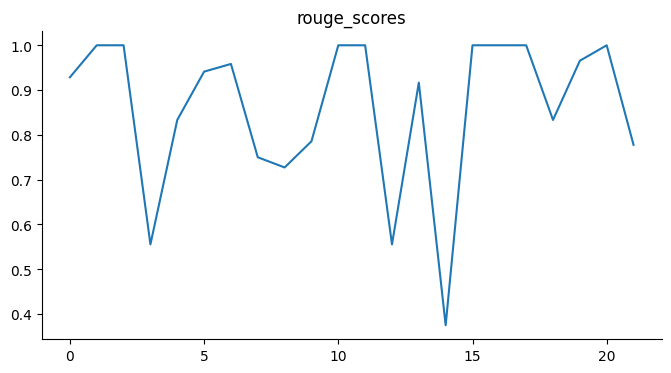

In [ ]:
# @title rouge_scores

from matplotlib import pyplot as plt
Validation_data['rouge_scores'].plot(kind='line', figsize=(8, 4), title='rouge_scores')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Mean Rouge score on validation data:
Validation_data.rouge_scores.mean()

0.8592639867764338